# Sparkify - Capstone Project

In this notebook a capstone project for a Udacity Nanodegree is presented.

<br>

## Scope of Work

Sparkify is a fictional music streaming application. Users can play songs, like/dislike songs, add them to playlist and add friends. There is a free and a paid user level. They can upgrade, downgrade or cancel their service at any time.<br>

The scope of this project is to do a churn prediction. Therefore users could get special offers before they quit the service.

The given data set contains every interaction of the users in Sparkify. This notebook only uses a tiny subset (128MB) of the full data set available (12GB). It comprises data of 255 users starting at the 1th of October 2018 until the 3rd of December 2018.

<br>

## Method

Pyspark is used to analyse the data and build three different ML models:
* Logistic Regression
* Naive Bayes
* Random Forest

For the data visualization Matplotlib and Seaborn is used. Numpy and Pandas are imported for some data handling.



In [1]:
# install pyspark
!pip install pyspark

     |████████████████████████████████| 281.4 MB 30 kB/s 
     |████████████████████████████████| 198 kB 46.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=6baf0e5607aad13fbe95afa56b4900c62f18ef80abc0ab9e90a7446da24ee6b6
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [2]:
# connect to Google drive
from google.colab import drive
drive.mount("/content/gdrive")

gpath = "/content/gdrive/MyDrive/Colab Notebooks/Sparkify/"

Mounted at /content/gdrive


In [3]:
# import libraries
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType
from pyspark.sql import Window

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, NaiveBayes, RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import json

import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# create a Spark session
spark = SparkSession.builder \
    .master("local[4]") \
    .appName("Spark Project") \
    .getOrCreate()

In [5]:
spark.sparkContext.getConf().getAll()

[('spark.app.id', 'local-1646463328678'),
 ('spark.driver.port', '41375'),
 ('spark.master', 'local[4]'),
 ('spark.app.startTime', '1646463325398'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.host', '9f291d213c81'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.sql.warehouse.dir', 'file:/content/spark-warehouse'),
 ('spark.app.name', 'Spark Project'),
 ('spark.ui.showConsoleProgress', 'true')]

# 1. Load and Clean Dataset
In this notebook, the mini-dataset file is `mini_sparkify_event_data.json`. The dataset is loaded and cleaned, checking for invalid or missing data in userids or sessionids. 

In [6]:
# load json file and make it persist
df = spark.read.json(gpath + 'mini_sparkify_event_data.json')
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [7]:
# get size of df
print(df.count(), len(df.columns))

286500 18


#### Drop NaN for user Id

In [8]:
df = df.dropna(how="any", subset=["userId"])

In [9]:
# get size of df
print(df.count(), len(df.columns))

286500 18


#### Drop duplicates

In [10]:
df = df.dropDuplicates()

In [11]:
# get size of df
print(df.count(), len(df.columns))

286500 18


# 2. Exploratory Data Analysis (EDA)
EDA is performed on the small subset of the data. Three new features for churn, downgrade phase and duration of each user  with Sparkify are created.

### Explore Data
First of all basic properties like shape and data type of the dataset is explored. Then comparisons between churn and no-churn users are made to find significant differences.

In [12]:
# get first entry
df.toPandas().head(1).transpose()

,0
artist,The Futureheads
auth,Logged In
firstName,Ainsley
gender,F
itemInSession,80
lastName,Farley
length,120.81587
level,free
location,"McAllen-Edinburg-Mission, TX"
method,PUT


In [13]:
# print data types of dataframe
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [14]:
# get statistics of numerical features
df.describe().toPandas()

,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,count,228108,286500,278154,278154,286500,278154,228108,286500,278154,286500,286500,278154,286500,228108,286500,286500,278154,286500
1,mean,551.0852017937219,None,None,None,114.41421291448516,None,249.11718197783526,None,None,None,None,1.5353588340857468E12,1041.526554973822,Infinity,210.05459685863875,1.5409568898104746E12,None,59682.02278593872
2,stddev,1217.7693079161377,None,None,None,129.76726201141113,None,99.23517921058296,None,None,None,None,3.291321616327394E9,726.7762634630824,NaN,31.50507848842203,1.507543960819584E9,None,109091.9499991055
3,min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",GET,About,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",
4,max,ÃÂlafur Arnalds,Logged Out,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99


In [15]:
# check for NaN
df.select([F.count(F.when(F.isnan(c), c)).alias(c) for c in df.columns]).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
# check for missing values in userId
df.where(df.userId == '').toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged Out,None,None,1,None,NaN,free,None,GET,Help,NaN,246,None,200,1538388594000,None,
1,None,Logged Out,None,None,0,None,NaN,paid,None,GET,Home,NaN,236,None,200,1538398122000,None,
2,None,Logged Out,None,None,26,None,NaN,free,None,GET,Home,NaN,186,None,200,1539006960000,None,
3,None,Logged Out,None,None,30,None,NaN,free,None,GET,About,NaN,439,None,200,1539023136000,None,
4,None,Logged Out,None,None,20,None,NaN,free,None,GET,Home,NaN,719,None,200,1539322963000,None,


In [17]:
# check for missing values in sessionId
df.where(df.sessionId == '').toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId


In [18]:
# get unique 'page' entries
df.select('page').distinct().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Settings'),
 Row(page='Login'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade'),
 Row(page='Submit Registration'),
 Row(page='Register')]

### 2.1 Create 'churn' column where column=1 if page='Cancellation Confirmation'

In [19]:
# set a flag if 'page' = 'Cancellation Confirmation'
flag_cancellation_event = F.udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("cancellation", flag_cancellation_event("page"))

In [20]:
# window over all timestamps in descending order
windowval = Window.partitionBy("userId").orderBy(F.desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [21]:
# sum flags over window
df = df.withColumn("churn", F.sum("cancellation").over(windowval))

### 2.2 Create Downgrade / Phase <br>
If user submits downgrade a flag is set. In the second step sum of flags is calculated using window function across descending timestamps.

In [22]:
# set a flag if 'page' = 'Submit Downgrade'
flag_downgrade_event = F.udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
df = df.withColumn("downgraded", flag_downgrade_event("page"))

In [23]:
# sum flags over window
df = df.withColumn("phase", F.sum("downgraded").over(windowval))

### 2.3 Explore Data

#### Get number of churned / not churned users

In [24]:
# get distint user id's for churn and no-churn users
churn_abs = df.select('userId').where(df.churn==1).distinct().count()
not_churn_abs = df.select('userId').where(df.churn==0).distinct().count()

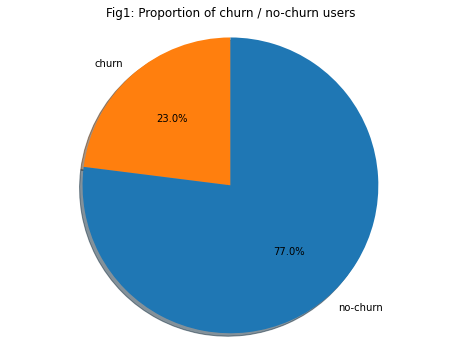

In [25]:
# create pie chart
labels = 'churn', 'no-churn'
sizes = [churn_abs, not_churn_abs]

fig1, ax1 = plt.subplots(figsize=(8, 6))
ax1.title.set_text('Fig1: Proportion of churn / no-churn users')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=['tab:orange', 'tab:blue'])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


#### What's the average song playing length of churned / not churned users?

In [26]:
# aggregate average song playing length for both user groups
print("Churn users:")
df.where((df.churn==1) & (df.page=='NextSong')).select('length').describe().show()

Churn users:
+-------+------------------+
|summary|            length|
+-------+------------------+
|  count|             36394|
|   mean|248.63279564406167|
| stddev| 102.3849771757548|
|    min|           4.04853|
|    max|        3024.66567|
+-------+------------------+



In [27]:
print("No-churn users:")
df.where((df.churn==0) & (df.page=='NextSong')).select('length').describe().show()

No-churn users:
+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           191714|
|   mean|249.2091353888089|
| stddev|98.62588300146908|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



#### Did churned or not churned users downgrade from paid to free more often?

In [28]:
# aggregate average downgrade phase for both user groups
churn_avg_phase = df.where(df.churn==1).agg(F.avg(df.phase)).collect()[0][0]
no_churn_avg_phase = df.where(df.churn==0).agg(F.avg(df.phase)).collect()[0][0]

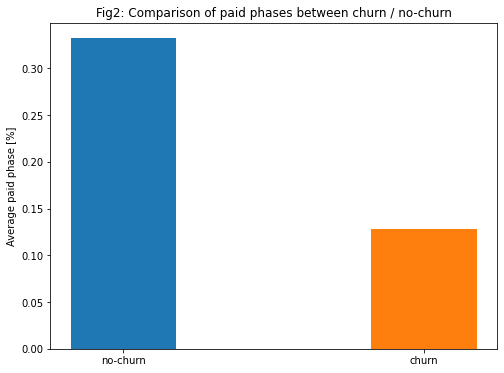

In [29]:
# create bar chart
x = [0, 1]
height = [no_churn_avg_phase, churn_avg_phase]
N = 2
ind = np.arange(N)    # the x locations for the groups
width = 0.35

fig2,ax1 = plt.subplots(figsize=(8, 6))
ax1.title.set_text('Fig2: Comparison of paid phases between churn / no-churn')
ax1.bar(x, height, width, color=['tab:blue', 'tab:orange'])
ax1.set_ylabel('Average paid phase [%]')
ax1.set_xticks(ind)
ax1.set_xticklabels(['no-churn', 'churn'])
plt.show()


#### How often did churned / not churned users dislike a song or downgrade it on average (per user)?

In [30]:
# count 'Thumbs Down' + 'Downgrade' page for both user groups divided by each user quantity
print("Number of disliked songs of churn users:")
df.where((df.churn==1) & ((df.page=='Thumbs Down') | (df.page=='Downgrade'))).count() / churn_abs

Number of disliked songs of churn users:


16.01923076923077

In [31]:
print("Number of disliked songs of no-churn users:")
df.where((df.churn==0) & ((df.page=='Thumbs Down') | (df.page=='Downgrade'))).count() / not_churn_abs

Number of disliked songs of no-churn users:


21.655172413793103

#### How often did churned / not churned users liked a song or add a song to a playlist on average?

In [32]:
# count 'Thumbs Up' page for both user groups divided by each user quantity
print("Number of liked songs of churn users:")
df.where((df.churn==1) & ((df.page=='Thumbs Up') | (df.page=='Add To Playlist'))).count() / churn_abs

Number of liked songs of churn users:


35.75

In [33]:
print("Number of liked songs of no-churn users:")
df.where((df.churn==0) & ((df.page=='Thumbs Up') | (df.page=='Add To Playlist'))).count() / not_churn_abs

Number of liked songs of no-churn users:


61.44827586206897

#### How many Songs did churned / not churned users play on average?

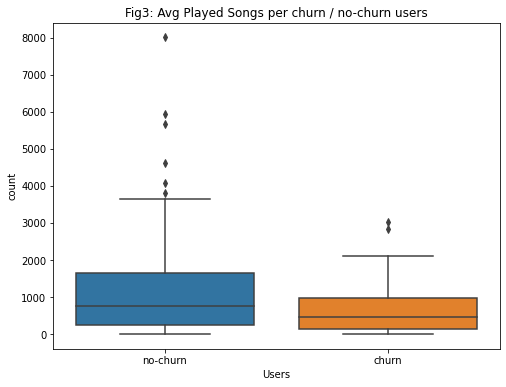

In [34]:
# count number of songs played by both user groups
song_count_df = df.where(df.page=='NextSong').groupby(['churn', 'userId']).count().toPandas()

# create boxplot
fig3,ax1 = plt.subplots(figsize=(8, 6))
sns.boxplot(x='churn', y='count', data=song_count_df)
ax1.set_title('Fig3: Avg Played Songs per churn / no-churn users')
ax1.set_xticklabels(['no-churn', 'churn'])
ax1.set_xlabel('Users')
plt.show()

#### Distribution between 'paid' and 'free' users of churned users

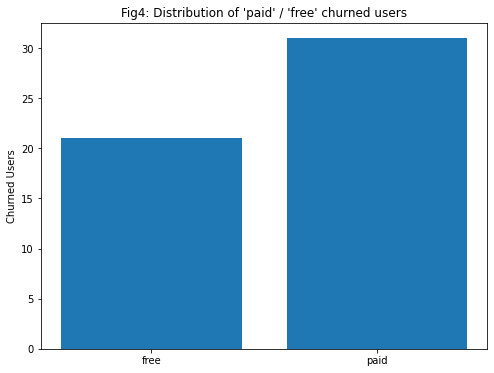

In [35]:
# count 'Cancellation Confirmation' for both user groups
churn_free = df.where((df.page=='Cancellation Confirmation') & (df.level=='free')).count()
churn_paid = df.where((df.page=='Cancellation Confirmation') & (df.level=='paid')).count()

# create bar chart
labels = ['free', 'paid']
height = [churn_free, churn_paid]

fig4,ax1 = plt.subplots(figsize=(8, 6))

ax1.bar(x, height)
ax1.set_title("Fig4: Distribution of 'paid' / 'free' churned users")
ax1.set_ylabel('Churned Users')
ax1.set_xticks(ind)
ax1.set_xticklabels(['free', 'paid'])
plt.show()

### 2.4 Calculating Statistics per Day

In [36]:
# get first timestamp in dataset:
min_ts = df.agg(F.min(df.ts)).collect()[0][0]

In [37]:
# get latest timestamp in dataset:
max_ts = df.agg(F.max(df.ts)).collect()[0][0]

In [38]:
# udf to get weekday of timestamp
get_weekday = F.udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). weekday())

In [39]:
# create column for weekday
df = df.withColumn("wday", get_weekday(df.ts))

In [40]:
# head of data frame
df.head()

Row(artist=None, auth='Logged In', firstName='Bryanna', gender='F', itemInSession=43, lastName='Stone', length=None, level='free', location='Los Angeles-Long Beach-Anaheim, CA', method='PUT', page='Logout', registration=1537440271000, sessionId=201, song=None, status=307, ts=1543335219000, userAgent='Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; rv:31.0) Gecko/20100101 Firefox/31.0', userId='100008', cancellation=0, churn=0, downgraded=0, phase=0, wday='1')

#### How often played churned / not churned users songs during the week days on average?

In [41]:
# calculate average of churn user songs per weekday
churn_avg_df = df.where((df.churn==1) & (df.page == "NextSong")).groupby(df.wday)\
    .agg((F.count(df.wday) / churn_abs).alias('Songs per User')).orderBy(df.wday.cast("float")).collect()

churn_avg_values = []
for i in range(len(churn_avg_df)):
  churn_avg_values.append(churn_avg_df[i]['Songs per User'])

# calculate ration between weekdays and weekends
print(f"Ratio between week / weekend for churn users: {sum(churn_avg_values[:5]) / sum(churn_avg_values[-2:])}")

Ratio between week / weekend for churn users: 5.329391304347826


In [42]:
# calculate average of no-churn user songs per weekday
not_churn_avg_df = df.where((df.churn==0) & (df.page == "NextSong")).groupby(df.wday)\
    .agg((F.count(df.wday) / not_churn_abs).alias('Songs per User')).orderBy(df.wday.cast("float")).collect()

not_churn_avg_values = []
for i in range(len(not_churn_avg_df)):
  not_churn_avg_values.append(not_churn_avg_df[i]['Songs per User'])

# calculate ration between weekdays and weekends
print(f"Ratio between week / weekend for no-churn users: {sum(not_churn_avg_values[:5]) / sum(not_churn_avg_values[-2:])}")

Ratio between week / weekend for no-churn users: 4.530317890728668


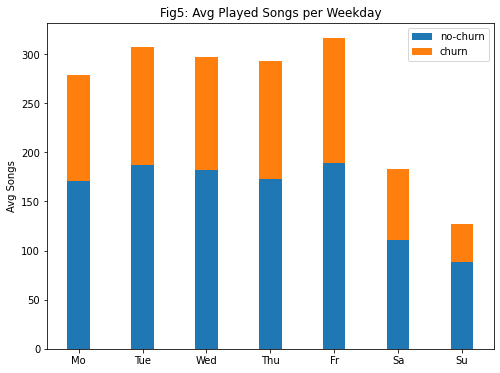

In [43]:
# create stacked bar chart of avg songs per weekday for both groups
labels = ['Mo', 'Tue', 'Wed', 'Thu', 'Fr', 'Sa', 'Su']
width = 0.35

fig5, ax1 = plt.subplots(figsize=(8, 6))

ax1.bar(labels, not_churn_avg_values, width, label='no-churn')
ax1.bar(labels, churn_avg_values, width, bottom=not_churn_avg_values,
       label='churn')

ax1.set_ylabel('Avg Songs')
ax1.set_title('Fig5: Avg Played Songs per Weekday')
ax1.legend()

plt.show()

#### Distribution of 'page' entries

In [44]:
# count all 'page' entries, sort descending
page_df = df.groupBy(df.page).count().sort(F.col("count").desc()).toPandas()
height = page_df['count'].tolist()
labels = page_df.page.tolist()

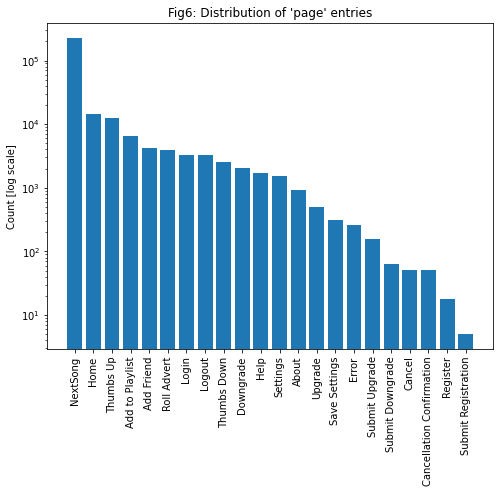

In [45]:
# create bar plot
fig6,ax1 = plt.subplots(figsize=(8, 6))
ax1.bar(labels, height)
ax1.set_title("Fig6: Distribution of 'page' entries")
plt.ylabel('Count [log scale]')
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()

In [46]:
# head of data frame
page_df.head(10)

,page,count
0,NextSong,228108
1,Home,14457
2,Thumbs Up,12551
3,Add to Playlist,6526
4,Add Friend,4277
5,Roll Advert,3933
6,Login,3241
7,Logout,3226
8,Thumbs Down,2546
9,Downgrade,2055


### 2.5 Findings:<br>
* Groups of churn / not-churned users is unbalanced (23% / 77%).
* Paid users are more presented then free users is both groups (Figure 2 and 4).
* Not churned users play more songs on average than churn users.
* Both groups play less songs on weekends. Ratio between week / weekend is greater for churn users (Figure 5).
* Not-churned user have a longer usage time. Therefore all statistics about not churned users have a greater impact (see next chapter).

# 3. Feature Engineering
In the first part of this section additional features are calculated to get a better presentation of the data. <br>

The main purpose of this work is to prepare user based data to train ML models. Therefore in the second to fourth parts new dataframes with one row per user id is generated using SQL queries. All features are transformed to numerical data.<br>

In the last part all subset are joined to the final dataset which will be used to train the models. Pearson coefficient is used to find correlated features and reduce them.

## 3.1 Create additional features

### Calculate usage period per user in days

'Usage period' is the difference between the first and the last timestamp for each user in the dataset.

In [47]:
# calculate usage period
df = df.withColumn("duration", F.round((F.col("ts").cast("long")/1000 - F.col("registration").cast("long")/1000)/86400, 4))

#### average usage period in days for churned / not churned users

In [48]:
# aggregate average user duration for churn users
df.where(df.churn==1).agg(F.avg(df.duration)).show()

+------------------+
|     avg(duration)|
+------------------+
|52.654033405402856|
+------------------+



In [49]:
# aggregate average user duration for no-churn users
df.where(df.churn==0).agg(F.avg(df.duration)).show()

+-----------------+
|    avg(duration)|
+-----------------+
|67.15457756826291|
+-----------------+



#### truncate feature "userAgent"

In [50]:
# create temp view of data frame
df.createOrReplaceTempView("df")

In [51]:
# get one userAgent entry per user using sql
user_agent_short = spark.sql('''
                            SELECT DISTINCT userId, MAX(userAgent) userAgent
                            FROM df
                            GROUP BY userId
                            ''').toPandas()

In [52]:
# drop NaN from query
user_agent_short = user_agent_short.dropna()

In [53]:
def get_os(x):
  '''
  function to check which OS is used for each userId

  INPUT: 'userAgent' column

  OUTPUT: 1=Mac, 2=WIN, 3=Linux else 0

  '''
  if 'Mac' in x:
    return 1
  elif 'Windows' in x:
    return 2
  elif 'Linux' in x:
    return 3
  else:
    return 0


In [54]:
# create new column 'os' from 'userAgent' using get_os()
user_agent_short['os'] = user_agent_short['userAgent'].apply(get_os)

In [55]:
# drop 'userAgent'
user_agent_short = user_agent_short.drop('userAgent', axis=1)

In [56]:
# check for 0
user_agent_short[user_agent_short.os == 0]

,userId,os


In [57]:
# create pyspark data frame
user_agent_py = spark.createDataFrame(user_agent_short)

In [58]:
# show head of pyspark data frame
user_agent_py.groupby(user_agent_py.os).count().show()

+---+-----+
| os|count|
+---+-----+
|  1|  102|
|  3|   12|
|  2|  111|
+---+-----+



## 3.2 Create subset dataframe of relevant features

In [59]:
# select relevant features from df
df_feat = df.select(['artist', 'gender', 'itemInSession', 'length', 'level', 'location', 'method', 'page',\
                     'registration', 'sessionId', 'song', 'status', 'ts', 'userId', 'churn', 'phase', 'wday',\
                     'duration'])

In [60]:
# convert userId, wday to integer
df_feat = df_feat.withColumn("userId", df_feat.userId.cast(IntegerType()))
df_feat = df_feat.withColumn("wday", df_feat.wday.cast(IntegerType()))

In [61]:
# head of data frame
df_feat.head()

Row(artist=None, gender='F', itemInSession=43, length=None, level='free', location='Los Angeles-Long Beach-Anaheim, CA', method='PUT', page='Logout', registration=1537440271000, sessionId=201, song=None, status=307, ts=1543335219000, userId=100008, churn=0, phase=0, wday=1, duration=68.2286)

## 3.3 Convert string features to numerical features

#### Convert 'gender' column to integer

In [62]:
# udf to convert gender feature to numerical data type
convert_gender = F.udf(lambda x: 1 if x == 'M' else 0, IntegerType())
# create new column 'gender_num' using udf
df_feat = df_feat.withColumn('gender_num', convert_gender(df_feat.gender))

#### 'length': Replace None with 0

In [63]:
df_feat = df_feat.fillna(0, subset=['length'])

#### Convert 'level' column to integer, get lastest level

In [64]:
# udf to convert level feature to numerical data type
convert_level = F.udf(lambda x: 1 if x == 'paid' else 0, IntegerType())
# create new column 'level_num' using udf
df_feat = df_feat.withColumn('level_num', convert_level(df_feat.level))

In [65]:
# get lastest level of each user
levels = df_feat.select(['userId', 'level_num', 'ts']).orderBy(F.desc('ts')).dropDuplicates(['userId'])\
    .select(['userId', 'level_num'])

#### Convert 'location' column to Divison Columns

source: https://github.com/cphalpert/census-regions/blob/master/us%20census%20bureau%20regions%20and%20divisions.csv

In [66]:
df_feat.select(['location']).head(5)

[Row(location='McAllen-Edinburg-Mission, TX'),
 Row(location='McAllen-Edinburg-Mission, TX'),
 Row(location='Tampa-St. Petersburg-Clearwater, FL'),
 Row(location=None),
 Row(location='Morgantown, WV')]

In [67]:
# import csv file
region = spark.read.csv(gpath + 'devisions.csv', header=True)

In [68]:
# udf to get state code of location string if string is not None
find_loc = F.udf(lambda x: x.split(', ')[1].split('-')[0] if x is not None else x)
# udf to lower state code and create new column name
loc_name = F.udf(lambda x: 'state_'+x.replace(' ', '_').lower())

# create new data frame with unique state codes of df_feat
locations = df_feat.withColumn('location', find_loc(df_feat.location))\
        .select(['userId', 'location']).filter(df_feat.location.isNotNull()).dropDuplicates(subset=['userId'])

# join division name from region csv file
locations = locations.join(region, locations.location == region['State Code'], how='left')\
    .select(['userId', F.col("Division").alias("location")])\
    .withColumn('location', loc_name('location'))

locations = locations.groupBy('userId').pivot('location').agg(F.count('location')).fillna(0)

In [69]:
# show locations data frame
print(f"{locations.count()} rows.")
locations.toPandas().head(5)

225 rows.


,userId,state_east_north_central,state_east_south_central,state_middle_atlantic,state_mountain,state_new_england,state_pacific,state_south_atlantic,state_west_north_central,state_west_south_central
0,148,0,0,0,0,0,0,1,0,0
1,137,0,0,1,0,0,0,0,0,0
2,85,0,0,0,0,0,1,0,0,0
3,200001,0,0,0,0,0,0,1,0,0
4,65,0,0,0,0,1,0,0,0,0


#### Convert 'method' column to integer

In [70]:
df_feat.select('method').distinct().show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [71]:
# udf to convert 'method' column to numerical data type
convert_method = F.udf(lambda x: 1 if x == 'PUT' else 0, IntegerType())
# create new column 'method_num' using udf
df_feat = df_feat.withColumn('method_num', convert_method(df_feat.method))

## 3.4 Create Datasets with one row per user

In [72]:
# create temp view of df_feat
df_feat.createOrReplaceTempView("df_feat")

### User Dataframe

In [73]:
# create a user dataframe using sql query
user_num = spark.sql(
    '''
    SELECT userId, AVG(gender_num) gender, AVG(length) length,
    AVG(itemInSession) itemInSession , AVG(method_num) method, MIN(registration) registration, AVG(status) status,
    MAX(churn) churn, AVG(wday) avg_wday, MAX(duration) user_duration
    FROM df_feat
    GROUP BY userId
    '''
)

print(f"{user_num.count()} rows.")
user_num.toPandas().head(5)

226 rows.


,userId,gender,length,itemInSession,method,registration,status,churn,avg_wday,user_duration
0,85.0,1.0,208.029513,147.250343,0.932265,1.534134e+12,208.663158,0,2.382380,109.6045
1,133.0,1.0,182.481006,23.045455,0.909091,1.536126e+12,212.159091,0,0.000000,39.8801
2,155.0,0.0,198.382527,120.156687,0.929142,1.541370e+12,209.901198,0,2.987026,23.5560
3,34.0,1.0,177.138145,14.000000,0.849315,1.536659e+12,207.328767,0,2.178082,71.1430
4,101.0,1.0,208.219644,259.667752,0.938576,1.535066e+12,208.201489,1,1.903211,53.9659


In [74]:
# check for NaN
user_num.select([F.count(F.when(F.isnan(c), c)).alias(c) for c in user_num.columns]).toPandas()

,userId,gender,length,itemInSession,method,registration,status,churn,avg_wday,user_duration
0,0,0,0,0,0,0,0,0,0,0


### Pages Dataframe

In [75]:
# create a dataframe containing counts of all pages per userId
page_name = F.udf(lambda x: 'page_' + x.replace(" ", "_").lower())

user_pages = df_feat.select(['userId', 'page']).withColumn('page', page_name(df_feat.page))\
    .groupBy(['userId']).pivot("page").agg(F.count('page'))

# drop userId == 0 (NaN), fill rest of NaN with 0
user_pages = user_pages.where(F.col('userId').isNotNull()).fillna(0)

print(f"{user_pages.count()} rows.")
user_pages.toPandas().head(5)

225 rows.


,userId,page_about,page_add_friend,page_add_to_playlist,page_cancel,page_cancellation_confirmation,page_downgrade,page_error,page_help,page_home,...,page_register,page_roll_advert,page_save_settings,page_settings,page_submit_downgrade,page_submit_registration,page_submit_upgrade,page_thumbs_down,page_thumbs_up,page_upgrade
0,148,1,7,5,0,0,0,0,3,26,...,0,32,0,3,0,0,0,3,28,3
1,85,6,58,108,0,0,42,2,24,157,...,0,33,3,25,2,0,3,38,192,7
2,137,0,8,4,0,0,0,0,1,12,...,0,10,0,1,0,0,1,1,8,4
3,65,6,53,68,0,0,20,0,13,80,...,0,8,7,23,0,0,1,17,111,3
4,200001,0,0,3,1,1,0,0,1,10,...,0,3,2,6,0,0,0,1,10,1


In [76]:
# calculate average to check if one column only contains Null
user_pages.select(*[F.mean(c).alias(c) for c in user_pages.columns]).show()

+------------------+----------+-----------------+--------------------+------------------+------------------------------+-----------------+----------+------------------+-----------------+----------+------------------+------------------+-------------+----------------+------------------+-----------------+---------------------+------------------------+-------------------+------------------+------------------+------------------+
|            userId|page_about|  page_add_friend|page_add_to_playlist|       page_cancel|page_cancellation_confirmation|   page_downgrade|page_error|         page_help|        page_home|page_login|       page_logout|     page_nextsong|page_register|page_roll_advert|page_save_settings|    page_settings|page_submit_downgrade|page_submit_registration|page_submit_upgrade|  page_thumbs_down|    page_thumbs_up|      page_upgrade|
+------------------+----------+-----------------+--------------------+------------------+------------------------------+-----------------+------

In [77]:
# drop columns with average of 0
cols = ('page_login', 'page_register', 'page_submit_registration')
user_pages = user_pages.drop(*cols)

In [78]:
# drop 'Cancellation Confirmation' and 'Cancel'
# they are equal to churn, which would be a data leakage for the models
user_pages = user_pages.drop('page_cancellation_confirmation').drop('page_cancel')

In [79]:
# check for NaN
user_pages.select([F.count(F.when(F.isnan(c), c)).alias(c) for c in user_pages.columns]).toPandas()

,userId,page_about,page_add_friend,page_add_to_playlist,page_downgrade,page_error,page_help,page_home,page_logout,page_nextsong,page_roll_advert,page_save_settings,page_settings,page_submit_downgrade,page_submit_upgrade,page_thumbs_down,page_thumbs_up,page_upgrade
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Artists / Song Dataframe

In [80]:
# count number of distinct artists, number of songs played and number of distinct songs
artists_num = spark.sql(
    '''
    SELECT userId, COUNT(DISTINCT artist) num_artists_dist, 
    COUNT(song) num_songs, COUNT(DISTINCT song) num_songs_dist
    FROM df_feat
    GROUP BY userId
    '''
)

print(f"{artists_num.count()} rows.")
artists_num.toPandas().head(5)

226 rows.


,userId,num_artists_dist,num_songs,num_songs_dist
0,148.0,350,398,382
1,85.0,2124,3616,3069
2,137.0,143,154,153
3,65.0,1377,2113,1837
4,200001.0,110,115,114


In [81]:
# check for NaN
artists_num.select([F.count(F.when(F.isnan(c), c)).alias(c) for c in artists_num.columns]).toPandas()

,userId,num_artists_dist,num_songs,num_songs_dist
0,0,0,0,0


## 3.5 Joining all features / reduce features

In [82]:
# join all data frame to get the final dataset of user data
users_dataset = user_num.join(locations, ['userId']).join(levels, ['userId'])\
            .join(user_pages, ['userId']).join(artists_num, ['userId']).join(user_agent_py, ['userId'])

users_dataset.toPandas().head(5)

,userId,gender,length,itemInSession,method,registration,status,churn,avg_wday,user_duration,...,page_settings,page_submit_downgrade,page_submit_upgrade,page_thumbs_down,page_thumbs_up,page_upgrade,num_artists_dist,num_songs,num_songs_dist,os
0,85,1.0,208.029513,147.250343,0.932265,1534133898000,208.663158,0,2.382380,109.6045,...,25,2,3,38,192,7,2124,3616,3069,1
1,133,1.0,182.481006,23.045455,0.909091,1536126401000,212.159091,0,0.000000,39.8801,...,0,0,0,0,2,0,32,32,32,2
2,155,0.0,198.382527,120.156687,0.929142,1541370470000,209.901198,0,2.987026,23.5560,...,5,0,1,3,58,2,643,820,759,2
3,34,1.0,177.138145,14.000000,0.849315,1536659447000,207.328767,0,2.178082,71.1430,...,0,0,0,0,2,0,53,53,53,1
4,101,1.0,208.219644,259.667752,0.938576,1535066380000,208.201489,1,1.903211,53.9659,...,9,0,1,16,86,1,1241,1797,1608,2


In [83]:
# get size
print(users_dataset.count(), len(users_dataset.columns))

225 41


### Calculate Pearson coefficient, drop features with p > 0.8

To reduce the number of features Pearson coefficient is used to calculuate correlation between all features and the churn property.

In [84]:
# convert dataset to Pandas data frame
feat_pd = users_dataset.toPandas()

In [85]:
# calculate all Pearson coefficients
corr_matrix = feat_pd.corr()

In [86]:
# head of correlation matrix
corr_matrix.head()

,userId,gender,length,itemInSession,method,registration,status,churn,avg_wday,user_duration,...,page_settings,page_submit_downgrade,page_submit_upgrade,page_thumbs_down,page_thumbs_up,page_upgrade,num_artists_dist,num_songs,num_songs_dist,os
userId,1.000000,0.033457,-0.109675,-0.167374,0.065387,-0.129478,0.381348,0.080377,0.119627,0.088018,...,-0.077690,0.034828,-0.010860,0.100255,0.121744,-0.066271,-0.065928,-0.060148,-0.062865,-0.001452
gender,0.033457,1.000000,-0.086499,-0.143234,-0.112388,0.040779,-0.024731,0.085340,-0.021228,-0.068573,...,-0.135859,-0.135001,-0.091387,-0.138126,-0.179652,-0.130428,-0.168961,-0.171895,-0.170751,-0.039365
length,-0.109675,-0.086499,1.000000,0.474025,0.857477,-0.113686,-0.420099,-0.241338,-0.014463,0.217337,...,0.319096,0.083866,0.214661,0.256494,0.324667,0.015389,0.428832,0.368963,0.393009,0.028913
itemInSession,-0.167374,-0.143234,0.474025,1.000000,0.526908,-0.033852,-0.179961,-0.121719,-0.037181,0.123985,...,0.428901,0.134218,0.321078,0.363171,0.416201,0.059527,0.562861,0.486518,0.518163,-0.009359
method,0.065387,-0.112388,0.857477,0.526908,1.000000,-0.129483,-0.022344,-0.218773,0.060667,0.228378,...,0.353167,0.085162,0.283669,0.319840,0.415034,-0.002008,0.482849,0.415872,0.442725,0.013752


In [87]:
# get lower triangle of corr matrix without diagonal
lower_tri = corr_matrix.where(np.tril(np.ones(corr_matrix.shape),k=-1).astype(np.bool))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [88]:
# create list of columns (=features) which are > 0.8
to_drop = [col for col in lower_tri.columns if any(np.abs(lower_tri[col]) > 0.8)]
print(to_drop)

['length', 'registration', 'page_add_friend', 'page_add_to_playlist', 'page_downgrade', 'page_help', 'page_home', 'page_logout', 'page_nextsong', 'page_settings', 'page_thumbs_down', 'page_thumbs_up', 'num_artists_dist', 'num_songs']


### Get Columns to Keep

In [89]:
# create list which features which are not dropped
cols_to_keep = feat_pd.columns.drop(to_drop).tolist()
# reduce correlation matrix containing only cols_to_keep
corr_matrix_remain = feat_pd[cols_to_keep].corr()
# get shape of corr matrix
corr_matrix_remain.shape

(27, 27)

### Plot correlation coefficients

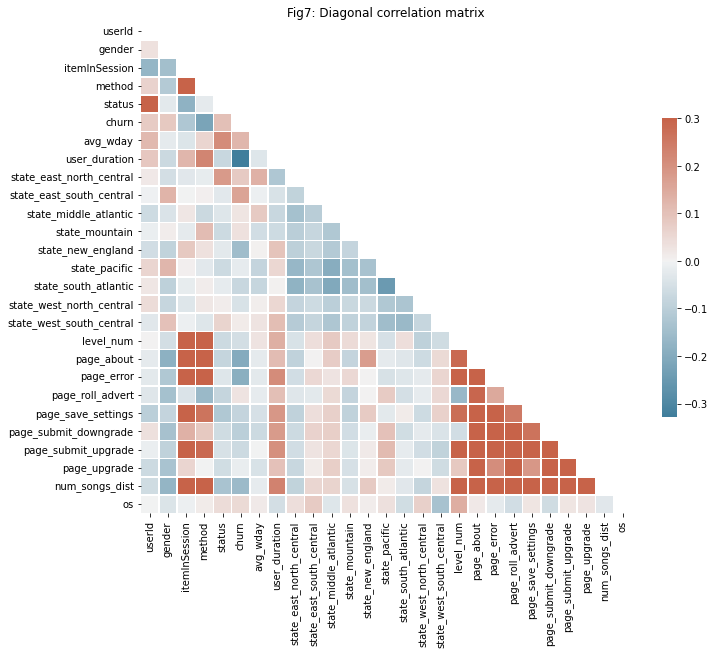

In [90]:
# Generate a mask for the lower triangle
mask = np.zeros_like(corr_matrix_remain, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix_remain, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title("Fig7: Diagonal correlation matrix")
plt.show()

In [91]:
# keep only features with low correlation + churn
# reduce dataset to cols_to_keep
dataset = users_dataset.select(cols_to_keep)

In [92]:
# check for missing values / get shape / show columns
dataset_pd = dataset.toPandas()
missing_count = dataset_pd.isnull().sum().sum()
print(f"Missing values in dataset: {missing_count}.")
print(f"Shape of dataset: {dataset_pd.shape}")
print(f"Columns of dataset: {dataset_pd.columns}")

Missing values in dataset: 0.
Shape of dataset: (225, 27)
Columns of dataset: Index(['userId', 'gender', 'itemInSession', 'method', 'status', 'churn',
       'avg_wday', 'user_duration', 'state_east_north_central',
       'state_east_south_central', 'state_middle_atlantic', 'state_mountain',
       'state_new_england', 'state_pacific', 'state_south_atlantic',
       'state_west_north_central', 'state_west_south_central', 'level_num',
       'page_about', 'page_error', 'page_roll_advert', 'page_save_settings',
       'page_submit_downgrade', 'page_submit_upgrade', 'page_upgrade',
       'num_songs_dist', 'os'],
      dtype='object')


# 4. Modeling
The data set is split into train, test and validation sets. Each model is trained and tested. The best model will be validated using the validation set. The following models are used:<br>

**Logistic Regression**<br>
It is used for binary variables. It learns a linear relationship from the given data and then uses the Sigmoid function to implement a non-linearity. It is easy to implement, interpret and very efficient to train.<br>
[https://www.geeksforgeeks.org/advantages-and-disadvantages-of-logistic-regression/]

**Naive Bayes**<br>
This model uses the Bayes' Theorem and assumes that all features are independent from each other thus there is no correlation between them. This assumption makes it very fast. It also works well with data with many features.
[https://towardsdatascience.com/naive-bayes-classifier-explained-50f9723571ed]

**Random Forest Classifier**<br>
This model builds many randomly generated dicision trees and averages over all predictions. It is relatively slow in training but has a lower risk of overfitting. This algorithm tends to be biased when dealing with categorical features.
[https://towardsai.net/p/machine-learning/why-choose-random-forest-and-not-decision-trees]

In [93]:
# rename churn column to 'label', convert to float
dataset = dataset.withColumn('label', dataset['churn'].cast('float')).drop('churn')

# get feature cols
feature_cols = dataset.drop('label').drop('userId').columns

In [94]:
# split into train, test, validation sets
train, test, validation = dataset.drop('userId').randomSplit([0.6, 0.2, 0.2], seed=42)

#### Evaluation

F1-score is choosen for the evaluation metric. Because the data is unbalanced (churn: 23%, not churn: 77%). Therefore accuracy would be relatively high, if the model would always predict "not churn". <br>
F1-score is a trade off between precision (positive prediction) and recall (sensitivity).

$$ F_{1} = \frac{2 * precision * recall}{precision + recall} $$

## 4.1 Logistic Regression

#### Feature Scaling
It is recommended for regression to scale the features so that the predictors have a mean of zero. This makes the intercept term easier to interpret as the expected value of Y when the predictor values are set to their means.

https://www.atoti.io/articles/when-to-perform-a-feature-scaling/#:~:text=Feature%20scaling%20is%20a%20method,during%20the%20data%20preprocessing%20step.

In [ ]:
# build pipeline
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
lr = LogisticRegression(labelCol="label", featuresCol="scaledFeatures", maxIter=10, regParam=0.0, elasticNetParam=0)
pipeline = Pipeline(stages=[assembler, scaler, lr])

In [ ]:
# param Grid
paramGrid = ParamGridBuilder().build()

# Cross validation
crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=MulticlassClassificationEvaluator(metricName='f1'),
    numFolds=3
)

In [ ]:
# train model
cvLrModel = crossval.fit(train)

In [ ]:
# evaluate on test data
pred_Lr = cvLrModel.transform(test)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")

accu = pred_Lr.where(pred_Lr.prediction == pred_Lr.label).count() / pred_Lr.count()
print(f"Accuracy: {round(accu, 4)}")
print("F1-score: ", evaluator.evaluate(pred_Lr, {evaluator.metricName: "f1"}))

Accuracy: 0.7963
F1-score:  0.7906013540422143


## 4.2 Naive Bayes

#### Feature Scaling
This algorithm is not distance based, but probability based. Therefore it does not require feature scaling.

https://medium.datadriveninvestor.com/naive-bayes-classifier-essential-things-to-know-c0d7d30b2954

In [ ]:
# build pipeline
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
Nb = NaiveBayes(labelCol="label", featuresCol="features", smoothing=1.0)
pipeline = Pipeline(stages=[assembler, Nb])

In [ ]:
# param Grid
paramGrid = ParamGridBuilder().build()

# Cross validation
crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=MulticlassClassificationEvaluator(metricName='f1'),
    numFolds=3
)

In [ ]:
# train model
cvNbModel = crossval.fit(train)

In [ ]:
# evaluate on test data
pred_Nb = cvNbModel.transform(test)#.select('label', 'prediction')
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName='f1')

accu = pred_Nb.where(pred_Nb.prediction == pred_Nb.label).count() / pred_Nb.count()
print(f"Accuracy: {round(accu, 4)}")
print("F1-score: ", evaluator.evaluate(pred_Nb, {evaluator.metricName: "f1"}))

Accuracy: 0.4815
F1-score:  0.5455337690631807


## 4.3 Random Forest

The Random Forest Classifier is a decision tree based algorithm which is not affected by feature scaling. Therefore no scaler is used here.

In [95]:
# build pipeline
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
Rf = RandomForestClassifier(labelCol="label", featuresCol="features", maxDepth=5, numTrees=30, seed=42)
pipeline = Pipeline(stages=[assembler, Rf])

In [96]:
# param Grid
paramGrid = ParamGridBuilder().build()    

# Cross validation
crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=MulticlassClassificationEvaluator(metricName='f1'),
    numFolds=3
)

In [97]:
# train model
cvRfModel = crossval.fit(train)

In [98]:
# evaluate on test data
pred_Rf = cvRfModel.transform(test)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")

accu = pred_Rf.where(pred_Rf.prediction == pred_Rf.label).count() / pred_Rf.count()
print(f"Accuracy: {round(accu, 4)}")
print("F1-score: ", evaluator.evaluate(pred_Rf, {evaluator.metricName: "f1"}))

Accuracy: 0.8889
F1-score:  0.8589569160997731


### Hyperparamter Tuning

Logistic Regression implies a linear relationship of the features to the classes. Naive Bayes implies no correlation between all features. Both assumptions do not apply to this case. Therefore the scores show not the best results.

The Random Forest Classifier has the highest F1-score. Therefore the hyperparameter of this model are tuned using the parameter grid.

* Max. Depth: Overfitting should be avoided so I only increase the depth in steps of 2.
* Number of Trees: The trees are randomly generated. Thus overfitting is not a risk here.

The best model is then tested on the validation data.

In [101]:
# param Grid
paramGrid = ParamGridBuilder()\
    .addGrid(Rf.maxDepth,[5, 7]) \
    .addGrid(Rf.numTrees,[30, 50, 70]) \
    .build()
    

# Cross validation
crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=MulticlassClassificationEvaluator(metricName='f1'),
    numFolds=3
)

In [102]:
# train model
cvRfModel = crossval.fit(train)

In [103]:
# average metrics of each parameter setting on the training data:
cvRfModel.avgMetrics

[0.732695632531429,
 0.7917829804131646,
 0.721950029026583,
 0.7625704179692999,
 0.7904533605998663,
 0.7172419310981462]

In [104]:
# evaluate on validation data
pred_Rf = cvRfModel.transform(validation)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")

accu = pred_Rf.where(pred_Rf.prediction == pred_Rf.label).count() / pred_Rf.count()
print(f"Accuracy: {round(accu, 4)}")
print("F1-score: ", evaluator.evaluate(pred_Rf, {evaluator.metricName: "f1"}))

Accuracy: 0.8
F1-score:  0.7720310765815761


In [105]:
# get parameters of best model
bestModel = cvRfModel.bestModel
print("Max. depth of best model: ", bestModel.stages[-1]._java_obj.getMaxDepth())
print("Num. of trees of best model: ", bestModel.stages[-1]._java_obj.getNumTrees())

Max. depth of best model:  5
Num. of trees of best model:  50


## 4.4 Feature Importance

In [106]:
# get estimation of feature importances of best model
feature_imp = bestModel.stages[-1].featureImportances

# create pd dataframe of feature importances with labels
featImp_df = pd.DataFrame(data={'label': feature_cols, 'imp': feature_imp.toArray().tolist()})

# sort in ascending order
featImp_df.sort_values('imp', inplace=True)

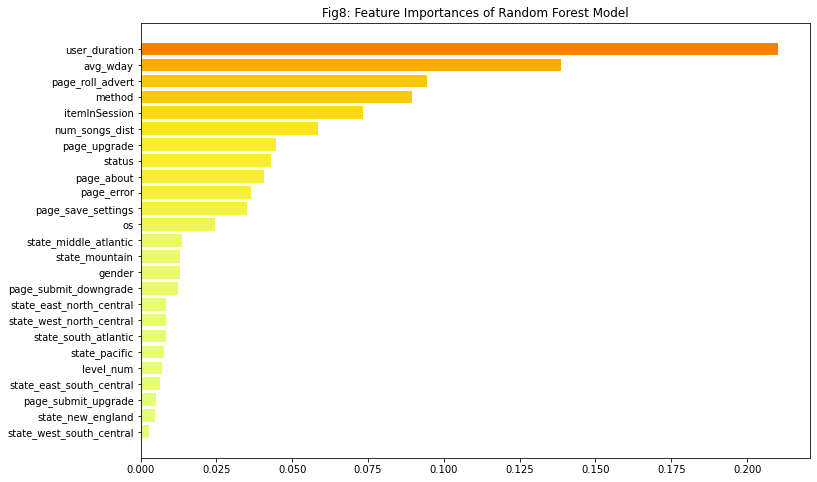

In [107]:
# create bar chart
labels = featImp_df.label
width = featImp_df.imp.values
y = range(len(feature_cols))
ind = np.arange(len(feature_cols))
height = 0.8

my_cmap = plt.get_cmap('Wistia')
rescale = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))

fig8,ax1 = plt.subplots(figsize=(12, 8))

ax1.barh(y, width, height, color=my_cmap(rescale(width)))
ax1.set_title("Fig8: Feature Importances of Random Forest Model")
ax1.set_yticks(ind)
ax1.set_yticklabels(labels)
plt.show()

In [ ]:
df_feat.select(['page', 'method']).distinct().toPandas().sort_values('method').head(30)

,page,method
10,Help,GET
19,Roll Advert,GET
2,About,GET
17,Home,GET
15,Cancellation Confirmation,GET
7,Settings,GET
14,Error,GET
13,Upgrade,GET
12,Register,GET
11,Downgrade,GET


In [ ]:
# investigate average method of churn and no-churn users
print("Average method of churn/no-churn users: ")
users_dataset.groupby(['churn']).agg(F.avg('method')).toPandas().head()

Average method of churn/no-churn users: 


,churn,avg(method)
0,0,0.910227
1,1,0.883070


In [ ]:
# investigate average weekday of churn and no-churn users
print("Average weekday of churn/no-churn users: ")
users_dataset.groupby(['churn']).agg(F.avg('avg_wday')).toPandas().head()

Average weekday of churn/no-churn users: 


,churn,avg(avg_wday)
0,0,2.581255
1,1,2.846070


In [ ]:
# investigate number of roll adverts in both groups
print("Average number of roll advertisment of both groups: ")
users_dataset.groupby(['churn']).agg(F.avg('page_roll_advert')).toPandas().head()

Average number of roll advertisment of both groups: 


,churn,avg(page_roll_advert)
0,0,17.144509
1,1,18.596154


In [ ]:
# investigate number of churn users in Middle Atlantic
print('Churn users in Middle Atlantic in %:')
round(users_dataset.where((users_dataset.state_middle_atlantic == 1) & (users_dataset.churn == 1)).count() \
  / users_dataset.where(users_dataset.state_middle_atlantic == 1).count() * 100, 2)

Churn users in Middle Atlantic in %:


25.81

# 5. Conclusion
User data from Sparkify was used to train a Random Forest Classifier to predict churn users. F1-score metric was used to get high precision as well as recall.

The final model has a acceptable F1-score of about 81.75% on the validation data. The model was only trained on a small subset. Using a spark cluster and the whole 12GB data set would probably increase the score significantly.

This model could be trained to predict the churn users on a weekly base and then send these users discounts or personalized offers. The impact of these actions could then be analysed with an A/B test.

In [ ]:
# convert notebook to html file

In [ ]:
#%%shell
#jupyter nbconvert --to html /content/Sparkify.ipynb

[NbConvertApp] Converting notebook /content/Sparkify.ipynb to html
[NbConvertApp] Writing 781451 bytes to /content/Sparkify.html
